In [1]:
from joblib import load

# 모델 불러오기
loaded_model = load("../Data/model.joblib")

print("모델이 성공적으로 불러와졌습니다.")

모델이 성공적으로 불러와졌습니다.


In [2]:
import pandas as pd
import holidays
from datetime import datetime

# 특징 생성 함수
def create_features_for_datetime(dt):
    """datetime에서 특징을 생성"""
    return {
        'datetime': dt,
        '연': dt.year,
        '월': dt.month,
        '일': dt.day,
        '시간': dt.hour,
        '요일': dt.weekday(),
        '주말': 1 if dt.weekday() >= 5 else 0,
        '공휴일': 1 if dt in holidays.KR() else 0,
    }

# 미래 예측 함수
def predict_passenger_count(model, future_datetime):
    """미래 승객 수 예측"""
    feature = create_features_for_datetime(future_datetime)
    feature_df = pd.DataFrame([feature])
    feature_columns = ['연', '월', '일', '시간', '요일', '주말', '공휴일']
    feature_input = feature_df[feature_columns]
    prediction = model.predict(feature_input)
    prediction = [max(0, round(float(val))) for val in prediction[0]]
    return {
        '10대': prediction[0],
        '20대': prediction[1],
        '30대': prediction[2],
        '40대': prediction[3],
        '50대 이상': prediction[4],
        '우대권': prediction[5],
        '외국인': prediction[6]
    }

# 특정 날짜의 시간대별 예측 함수
def predict_specific_date_all_hours(model, date_input):
    """특정 날짜의 0시부터 23시까지 모든 시간대의 승객 수 예측"""
    specific_date = datetime.strptime(date_input, '%Y%m%d')
    predictions = []
    for hour in range(24):
        if 1 <= hour <= 4:
            continue
        current_time = specific_date.replace(hour=hour, minute=0, second=0, microsecond=0)
        predicted_count = predict_passenger_count(model, current_time)
        predictions.append({
            'datetime': current_time.strftime('%Y-%m-%d %H:%M:%S'),
            **predicted_count
        })
    return pd.DataFrame(predictions)

In [3]:
# 특정 날짜 예측 실행
date_input = "20240524"  # YYYYMMDD 형식으로 날짜 입력
predictions_for_date = predict_specific_date_all_hours(loaded_model, date_input)

# 승객수 합계 열 추가
predictions_for_date['승객수 합계'] = predictions_for_date[['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']].sum(axis=1)

# 결과 출력
predictions_for_date

,datetime,10대,20대,30대,40대,50대 이상,우대권,외국인,승객수 합계
0,2024-05-24 00:00:00,76,187,355,206,114,19,2,959
1,2024-05-24 05:00:00,39,94,183,105,60,300,0,781
2,2024-05-24 06:00:00,189,459,929,542,297,616,0,3032
3,2024-05-24 07:00:00,218,1419,4041,2490,393,471,1,9033
4,2024-05-24 08:00:00,416,2603,7477,4601,734,571,3,16405
5,2024-05-24 09:00:00,386,2389,6790,4162,673,775,9,15184
6,2024-05-24 10:00:00,576,1345,2734,1567,881,863,18,7984
7,2024-05-24 11:00:00,463,1091,2182,1255,703,905,23,6622
8,2024-05-24 12:00:00,501,1145,2303,1318,749,840,24,6880
9,2024-05-24 13:00:00,588,1345,2712,1551,880,954,26,8056


In [4]:
import pandas as pd
df = pd.read_csv('../Data/강남 일별 시간대별 승객유형별 승하차인원 최종 분류.csv')

In [5]:
# 승객수 합계 컬럼 추가
df['승객수 합계'] = df[['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']].sum(axis=1)

# 필요한 컬럼만 필터링
filtered_df = df[['datetime','10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인', '승객수 합계']]

# datetime을 datetime 형식으로 변환
df['datetime'] = pd.to_datetime(df['datetime'])

# 24년 5월 24일 데이터 필터링
filtered_df = df[
    (df['datetime'].dt.year == 2024) & 
    (df['datetime'].dt.month == 5) & 
    (df['datetime'].dt.day == 24)
]

# 필요한 컬럼만 선택
filtered_df = filtered_df[['datetime', '10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인', '승객수 합계']]

# 결과 출력
filtered_df

,datetime,10대,20대,30대,40대,50대 이상,우대권,외국인,승객수 합계
14459,2024-05-24 00:00:00,81,190,384,221,124,16,1,1017
14460,2024-05-24 05:00:00,39,91,183,106,59,304,0,782
14461,2024-05-24 06:00:00,190,445,900,519,291,611,0,2956
14462,2024-05-24 07:00:00,222,1390,3953,2433,389,459,2,8848
14463,2024-05-24 08:00:00,423,2642,7512,4623,740,569,7,16516
14464,2024-05-24 09:00:00,382,2387,6789,4178,668,768,11,15183
14465,2024-05-24 10:00:00,585,1372,2774,1600,896,877,25,8129
14466,2024-05-24 11:00:00,463,1085,2194,1266,709,858,24,6599
14467,2024-05-24 12:00:00,495,1160,2347,1354,758,851,16,6981
14468,2024-05-24 13:00:00,569,1333,2697,1556,871,920,16,7962


In [6]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

import warnings
warnings.filterwarnings('ignore')

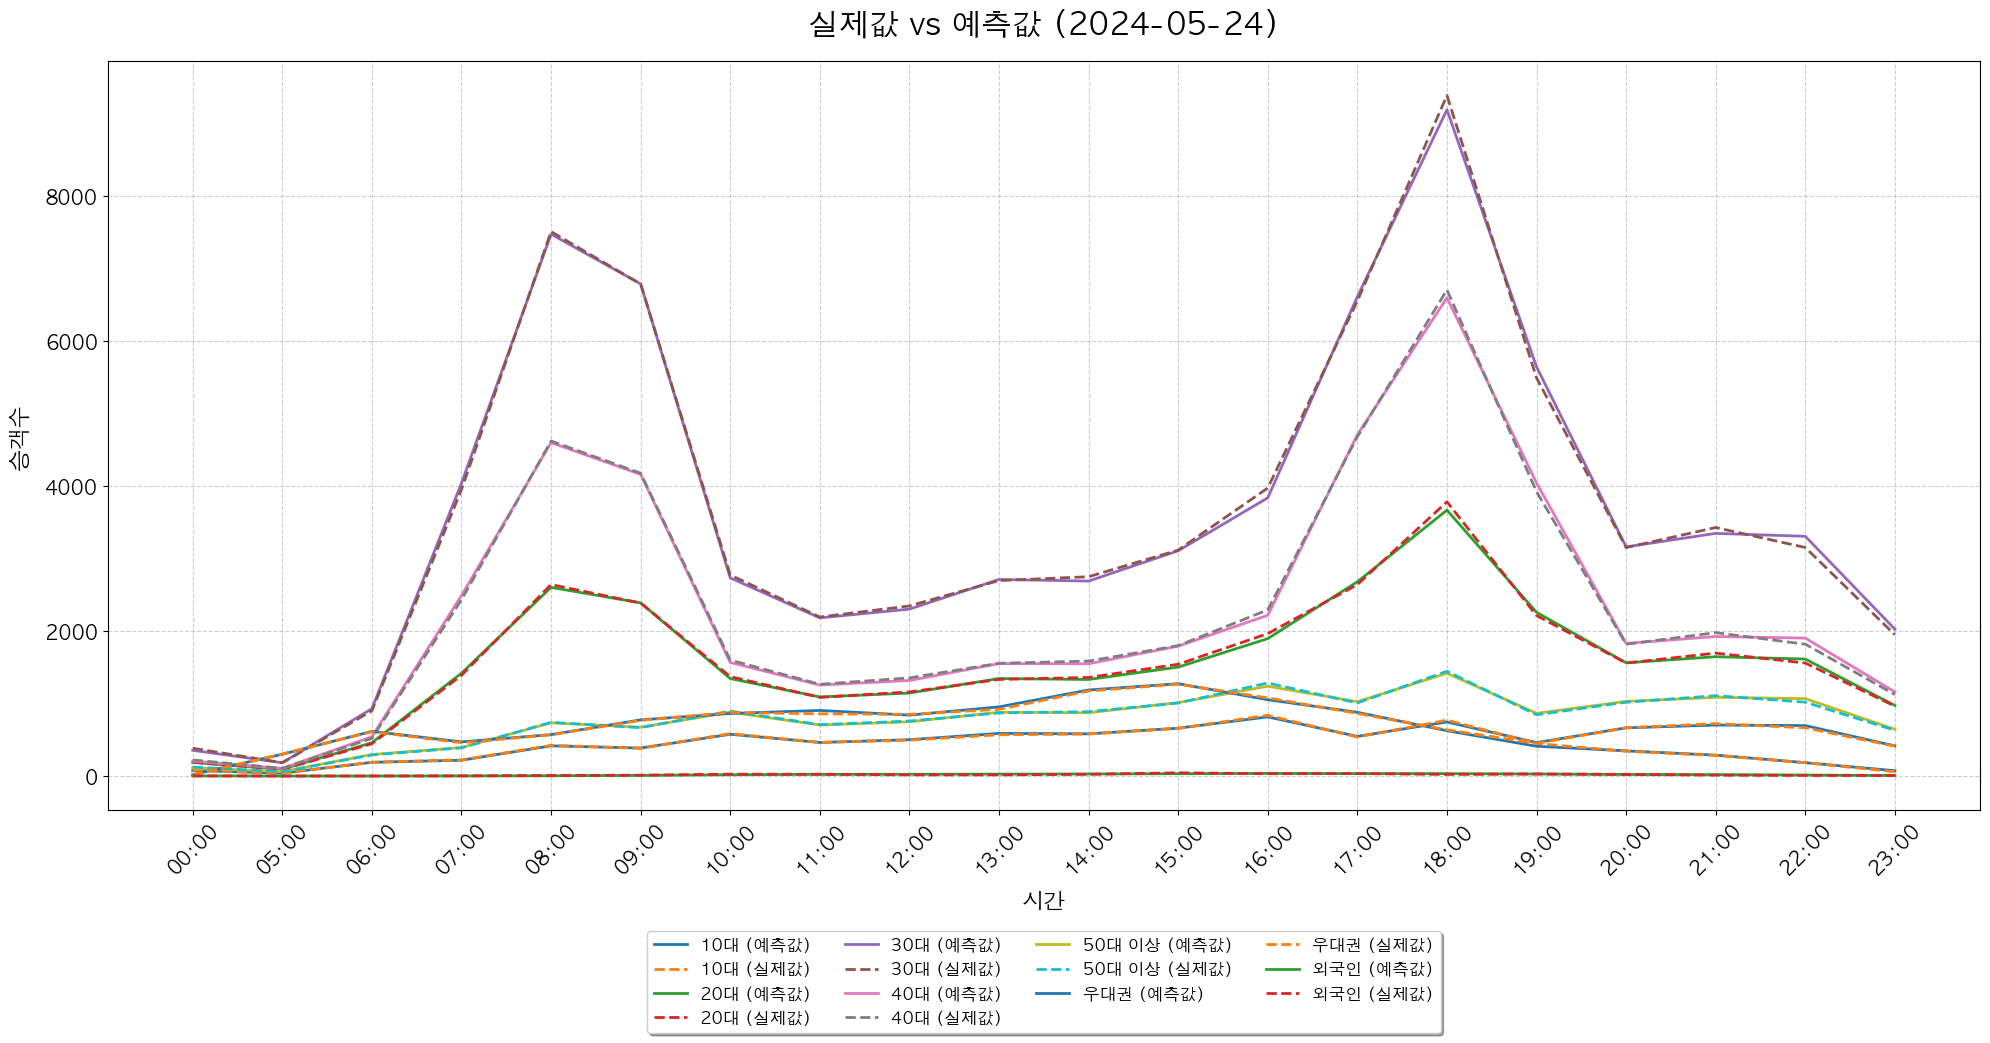

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 나이대 컬럼 리스트
age_groups = ['10대', '20대', '30대', '40대', '50대 이상', '우대권', '외국인']

# datetime 열을 datetime 형식으로 변환
predictions_for_date['datetime'] = pd.to_datetime(predictions_for_date['datetime'])
filtered_df['datetime'] = pd.to_datetime(filtered_df['datetime'])

# 시간만 추출
predictions_for_date['시간'] = predictions_for_date['datetime'].dt.strftime('%H:%M')
filtered_df['시간'] = filtered_df['datetime'].dt.strftime('%H:%M')

# 그래프 설정
plt.figure(figsize=(20, 12))  # 크기를 더 크게 설정

# 각 나이대의 예측값과 실제값을 동일한 그래프에 추가
for age_group in age_groups:
    plt.plot(predictions_for_date['시간'], predictions_for_date[age_group], 
             label=f'{age_group} (예측값)', linestyle='-', linewidth=2)
    plt.plot(filtered_df['시간'], filtered_df[age_group], 
             label=f'{age_group} (실제값)', linestyle='--', linewidth=2)

# 그래프 꾸미기
plt.title('실제값 vs 예측값 (2024-05-24)', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('시간', fontsize=16, labelpad=10)
plt.ylabel('승객수', fontsize=16, labelpad=10)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# 범례를 X축과 떨어진 위치에 배치
plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=True, shadow=True)

plt.grid(True, linestyle='--', alpha=0.6)

# 그래프 저장
plt.tight_layout(rect=[0, 0, 1, 0.9])
# plt.savefig('../Data/Predicted_vs_Actual_Passenger_Counts_Updated.png', dpi=600, bbox_inches='tight')  # DPI를 600으로 설정
plt.show()